In [76]:
import pandas as pd
df=pd.read_csv("dataTwitterF.csv")
df.text

0       Au bout de l'absurde peut-être la victoire aussi inattendue que belle. Le liquidateur a fait son...
1       Bonne nouvelle ! De la vaisselle réutilisable pour les fast-food VS tous les emballages à usage ...
2       Domac Français : plus de Royal Cheese. Plus de paille. Un Big Mac de moins en moins Big. Niquez-...
3       Catégorie Culture & Loisirs | Effie Bronze @McDonalds France pour OMY par @TBWA_PARIS OMD @Starc...
4       Catégorie Communication Corporate | Effie OR @McDonalds France pour CHEZ MCDO, J'APPRENDS A CHAQ...
                                                       ...                                                 
1921    Don't understand why everyone's surprised by hawa chicken's copycat of migros ad while mcdonalds...
1922                                                    @McDonalds McDonalds France ? Follow me pleaseeeeee
1923    Just avatared myself at www.avatarizeyourelf.com very cool widget! And by mcdonalds france? I ha...
1924    worlds second larges

In [0]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim
import spacy
import logging
import warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
#from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop 
sp1 =stopwords.words('french')
sp2 =stopwords.words('english')

stop_words=sp1+sp2+['http','https','bit','fr','was','com','to','of','are','or','gt','html','for','com','the','id','by','www','www','ly','in','is','with','amp','via','chez']

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [0]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [40]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.text.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['au', 'bout', 'de', 'labsurde', 'peut', 'etre', 'la', 'victoire', 'aussi', 'inattendue', 'que', 'belle', 'le', 'liquidateur', 'fait', 'son', 'travail', 'en', 'mettant', 'un', 'terme', 'la', 'franchise', 'mais', 'le', 'personnel', 'depend', 'aujourdhui', 'de', 'mcdonalds', 'france', 'ce', 'que', 'demandait', 'les', 'salaries', 'depuis', 'des', 'mois', 'lespoir', 'est', 'la']]


In [41]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
# or do
# !conda install -c conda-forge spacy-model-en_core_web_md 
# and use nlp=spacy.load('en_core_web_sm') instead in below function.
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


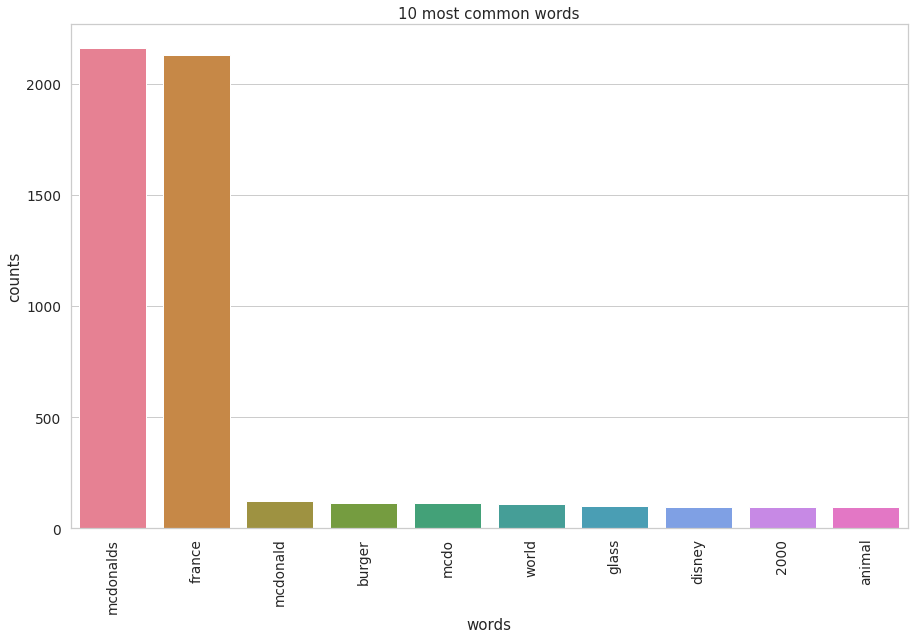

In [42]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words=stop_words )
# Fit and transform the processed titles!
count_data = count_vectorizer.fit_transform(data)
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)


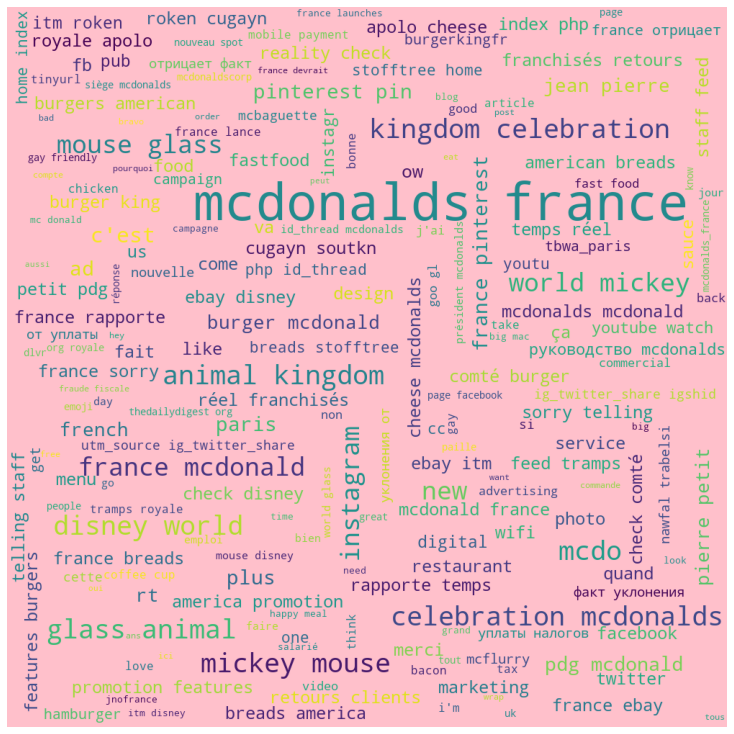

In [86]:
from wordcloud import WordCloud, STOPWORDS 
import sys,tweepy,csv,re
import matplotlib.pyplot as plt 
import pandas as pd 
  
comment_words = '' 
stop_word=stop_words+['ça','si']

# iterate through the csv file 
for val in df.text : 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 1000, height = 1000, 
                background_color ='pink', 
                stopwords = stop_word, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off")
plt.tight_layout(pad = 0) 
  
plt.show() 

# **Topic Modeling with LDA**

In [43]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)
id2word.filter_extremes(no_below=7, no_above=0.8, keep_n=1000000)
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]
tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=15,
                                           passes=120,
                                           alpha='symmetric',
                                           iterations=120,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.159*"mcdonald" + 0.104*"eat" + 0.071*"ca" + 0.060*"design" + 0.054*"wifi" '
  '+ 0.050*"know" + 0.049*"brand" + 0.044*"feature" + 0.040*"think" + '
  '0.040*"order"'),
 (1,
  '0.202*"ad" + 0.061*"youtube" + 0.055*"watch" + 0.055*"love" + 0.050*"say" + '
  '0.048*"get" + 0.048*"french" + 0.039*"make" + 0.038*"need" + 0.036*"look"'),
 (2,
  '0.202*"come" + 0.107*"new" + 0.082*"go" + 0.047*"take" + 0.042*"france" + '
  '0.041*"cool" + 0.038*"campaign" + 0.033*"burger" + 0.030*"macaron" + '
  '0.029*"use"'),
 (3,
  '0.133*"advertisement" + 0.099*"photograph" + 0.078*"commercial" + '
  '0.058*"tinyurl" + 0.051*"market" + 0.049*"franchise" + 0.043*"restaurant" + '
  '0.036*"much" + 0.034*"news" + 0.033*"launch"')]


In [74]:
num_topic=4
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 20);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);
get_lda_topics(lda_model, num_topic)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04
0,mcdonald,ad,come,advertisement
1,eat,youtube,new,photograph
2,ca,watch,go,commercial
3,design,love,take,tinyurl
4,wifi,say,france,market
5,know,get,cool,franchise
6,brand,french,campaign,restaurant
7,feature,make,burger,much
8,think,need,macaron,news
9,order,look,use,launch


In [45]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic i each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.6250,"advertisement, photograph, commercial, tinyurl, market, franchise, restaurant, much, news, launch","[travail, mettant, franchise, personnel, depend]"
1,1,0.0,0.7454,"mcdonald, eat, ca, design, wifi, know, brand, feature, think, order","[tous, emballage, usage, moin, tonne, dechet]"
2,2,0.0,0.6250,"mcdonald, eat, ca, design, wifi, know, brand, feature, think, order","[moin, mcdonald]"
3,3,0.0,0.2500,"mcdonald, eat, ca, design, wifi, know, brand, feature, think, order",[]
4,4,0.0,0.2500,"mcdonald, eat, ca, design, wifi, know, brand, feature, think, order","[effie, effiefrance]"
5,5,3.0,0.6248,"advertisement, photograph, commercial, tinyurl, market, franchise, restaurant, much, news, launch","[effie, argent, mccafe, story, effie]"
6,6,1.0,0.7500,"ad, youtube, watch, love, say, get, french, make, need, look","[french, fry, however, thing, potatoe]"
7,7,0.0,0.6250,"mcdonald, eat, ca, design, wifi, know, brand, feature, think, order","[paille, plastique, comme, ca, gobelet, jete, bord, autoroute, paille, finissent, savetheturtle]"
8,8,0.0,0.2500,"mcdonald, eat, ca, design, wifi, know, brand, feature, think, order","[font, tmqmmgbalfp]"
9,9,2.0,0.6250,"come, new, go, take, france, cool, campaign, burger, macaron, use","[slay, non, plastic, cup, take, note]"


In [61]:
df_dominant_topic.shape

(1926, 5)

In [46]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.8747,"mcdonald, eat, ca, design, wifi, know, brand, feature, think, order","[bad, customerservice, mcdonald, physical, assault, mcdonald, physical, assault]"
1,1.0,0.8500,"ad, youtube, watch, love, say, get, french, make, need, look","[french, love, french, love]"
2,2.0,0.8500,"come, new, go, take, france, cool, campaign, burger, macaron, use","[new, come, campaign, support, gay, consumer, cool, auciod]"
3,3.0,0.8499,"advertisement, photograph, commercial, tinyurl, market, franchise, restaurant, much, news, launch","[feel, heat, tax, spiderfinance, feel, tax]"


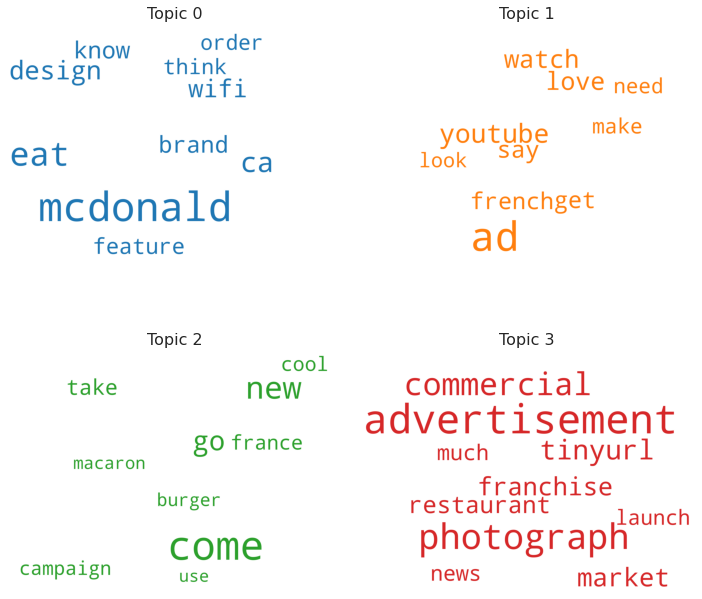

In [47]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

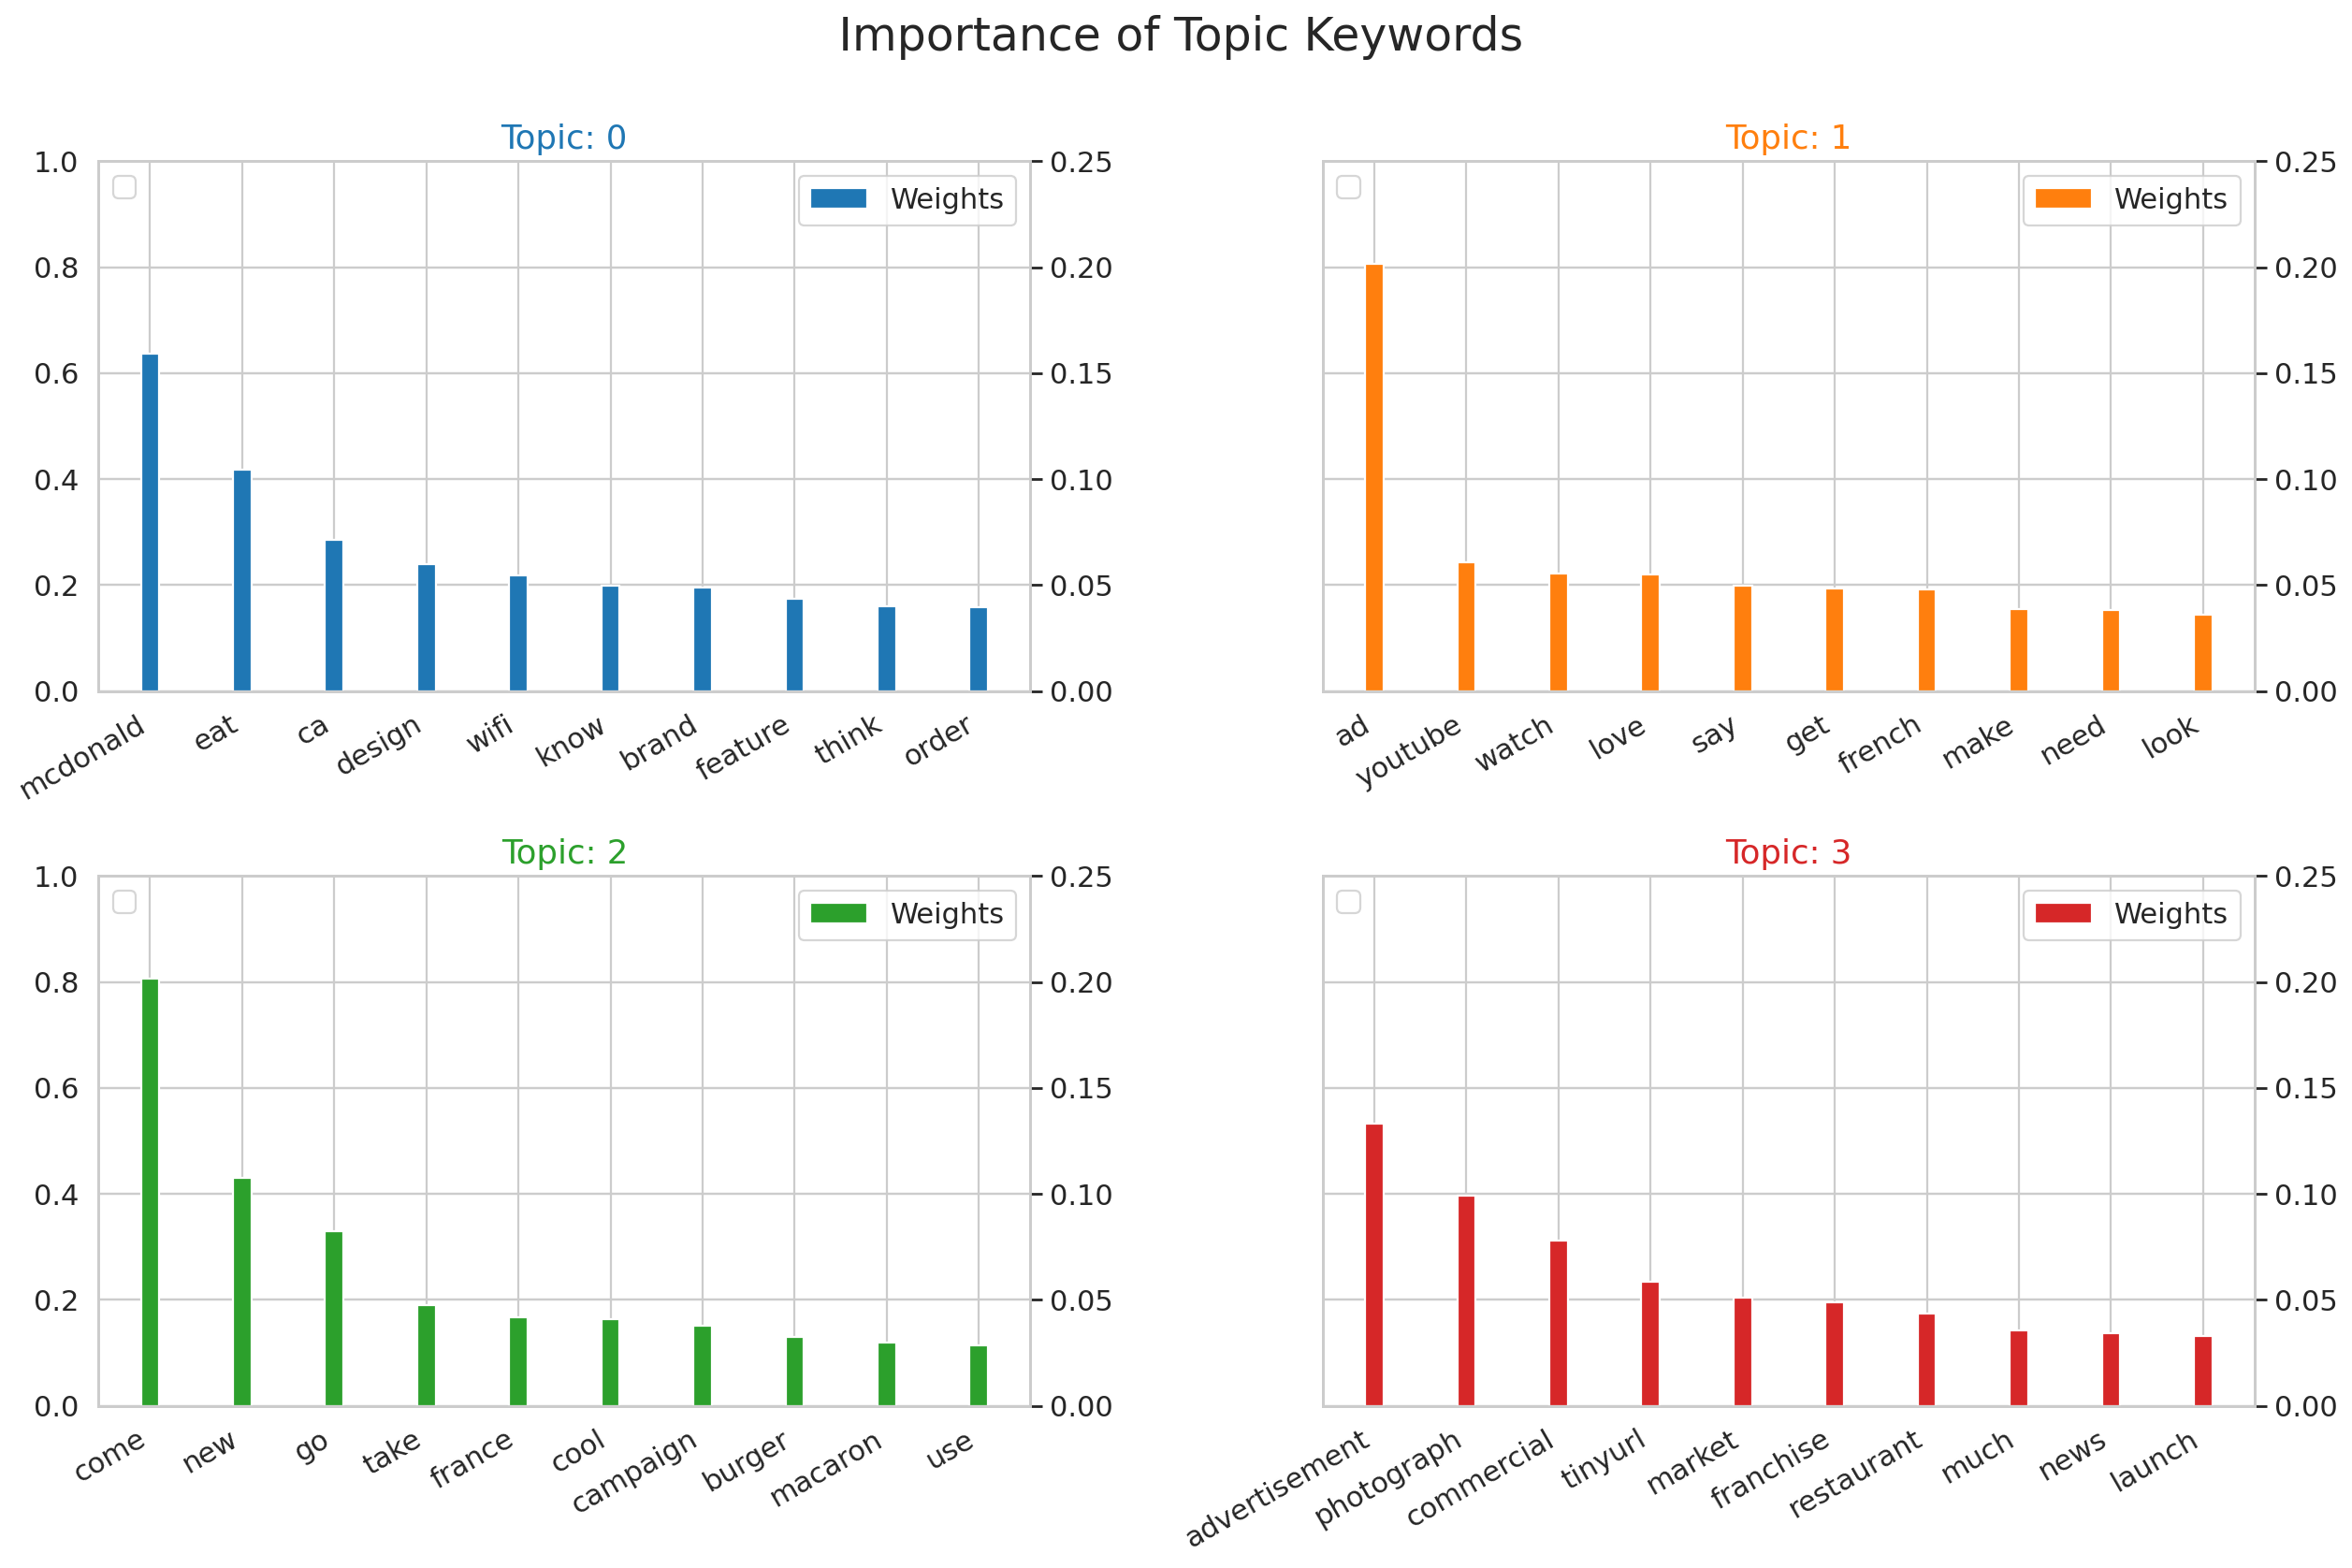

In [48]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    #ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    #ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.25); 
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle(' Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

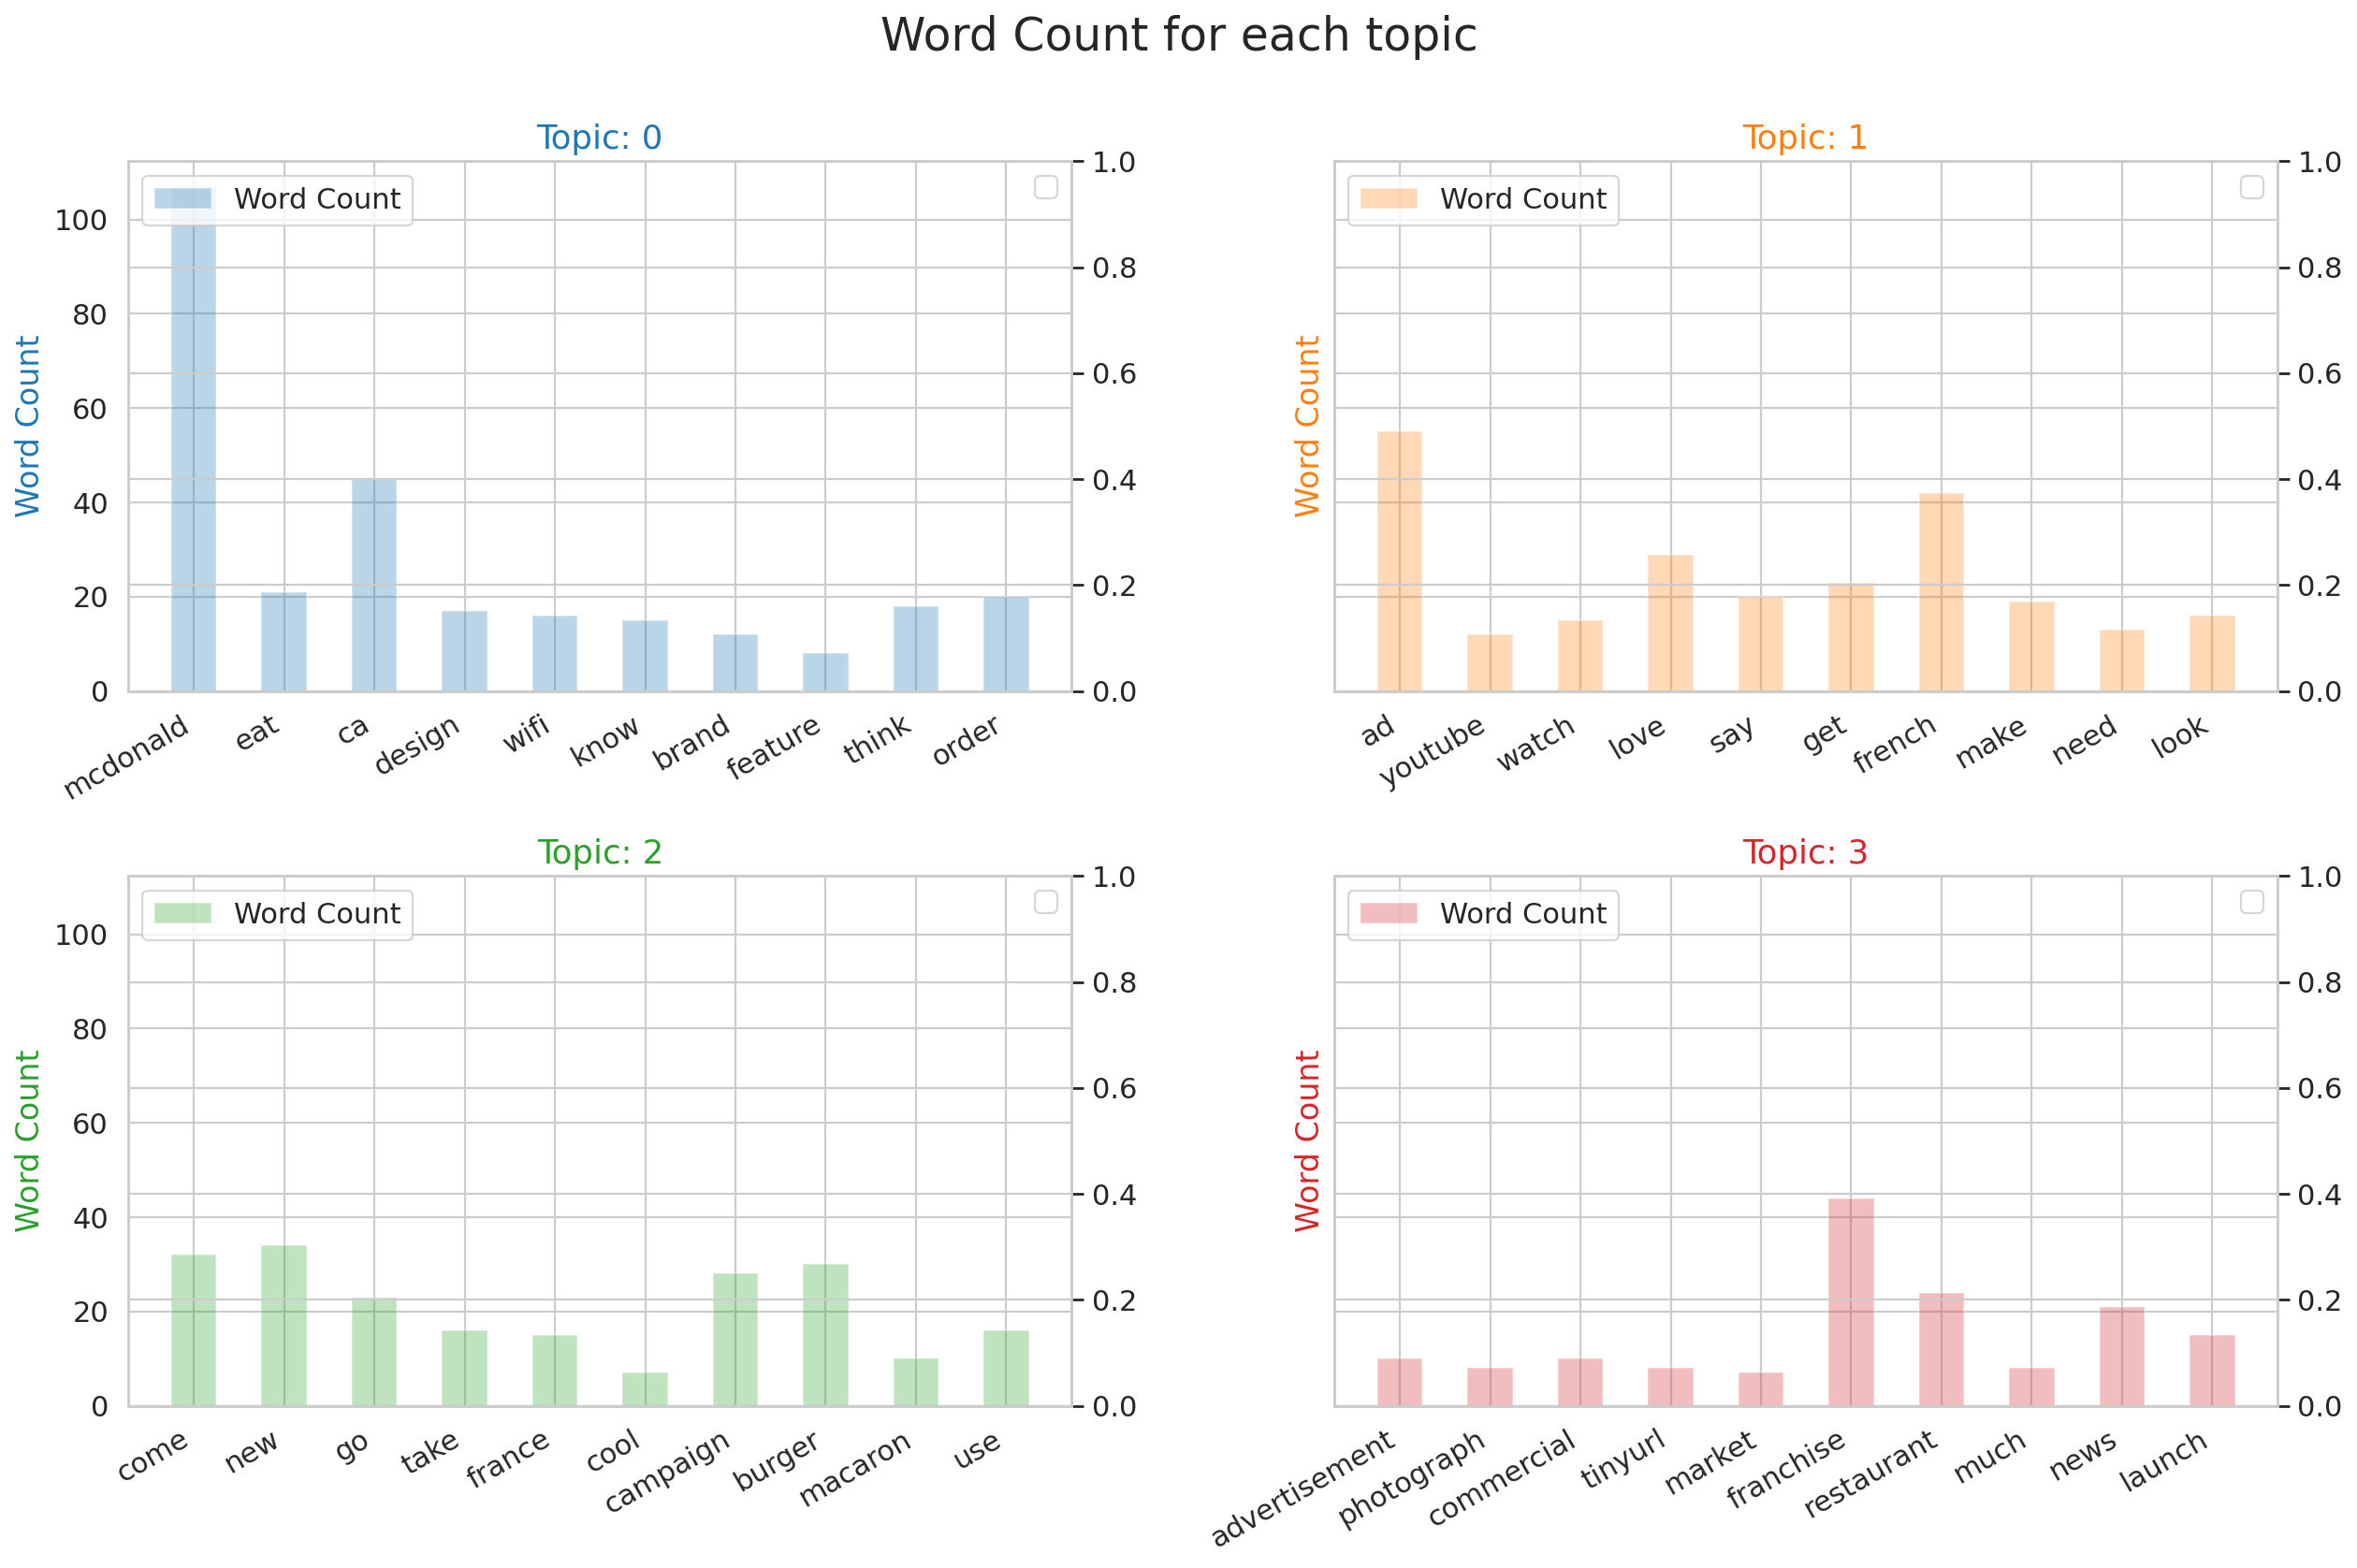

In [49]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    #ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    #ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count for each topic', fontsize=22, y=1.05)    
plt.show()

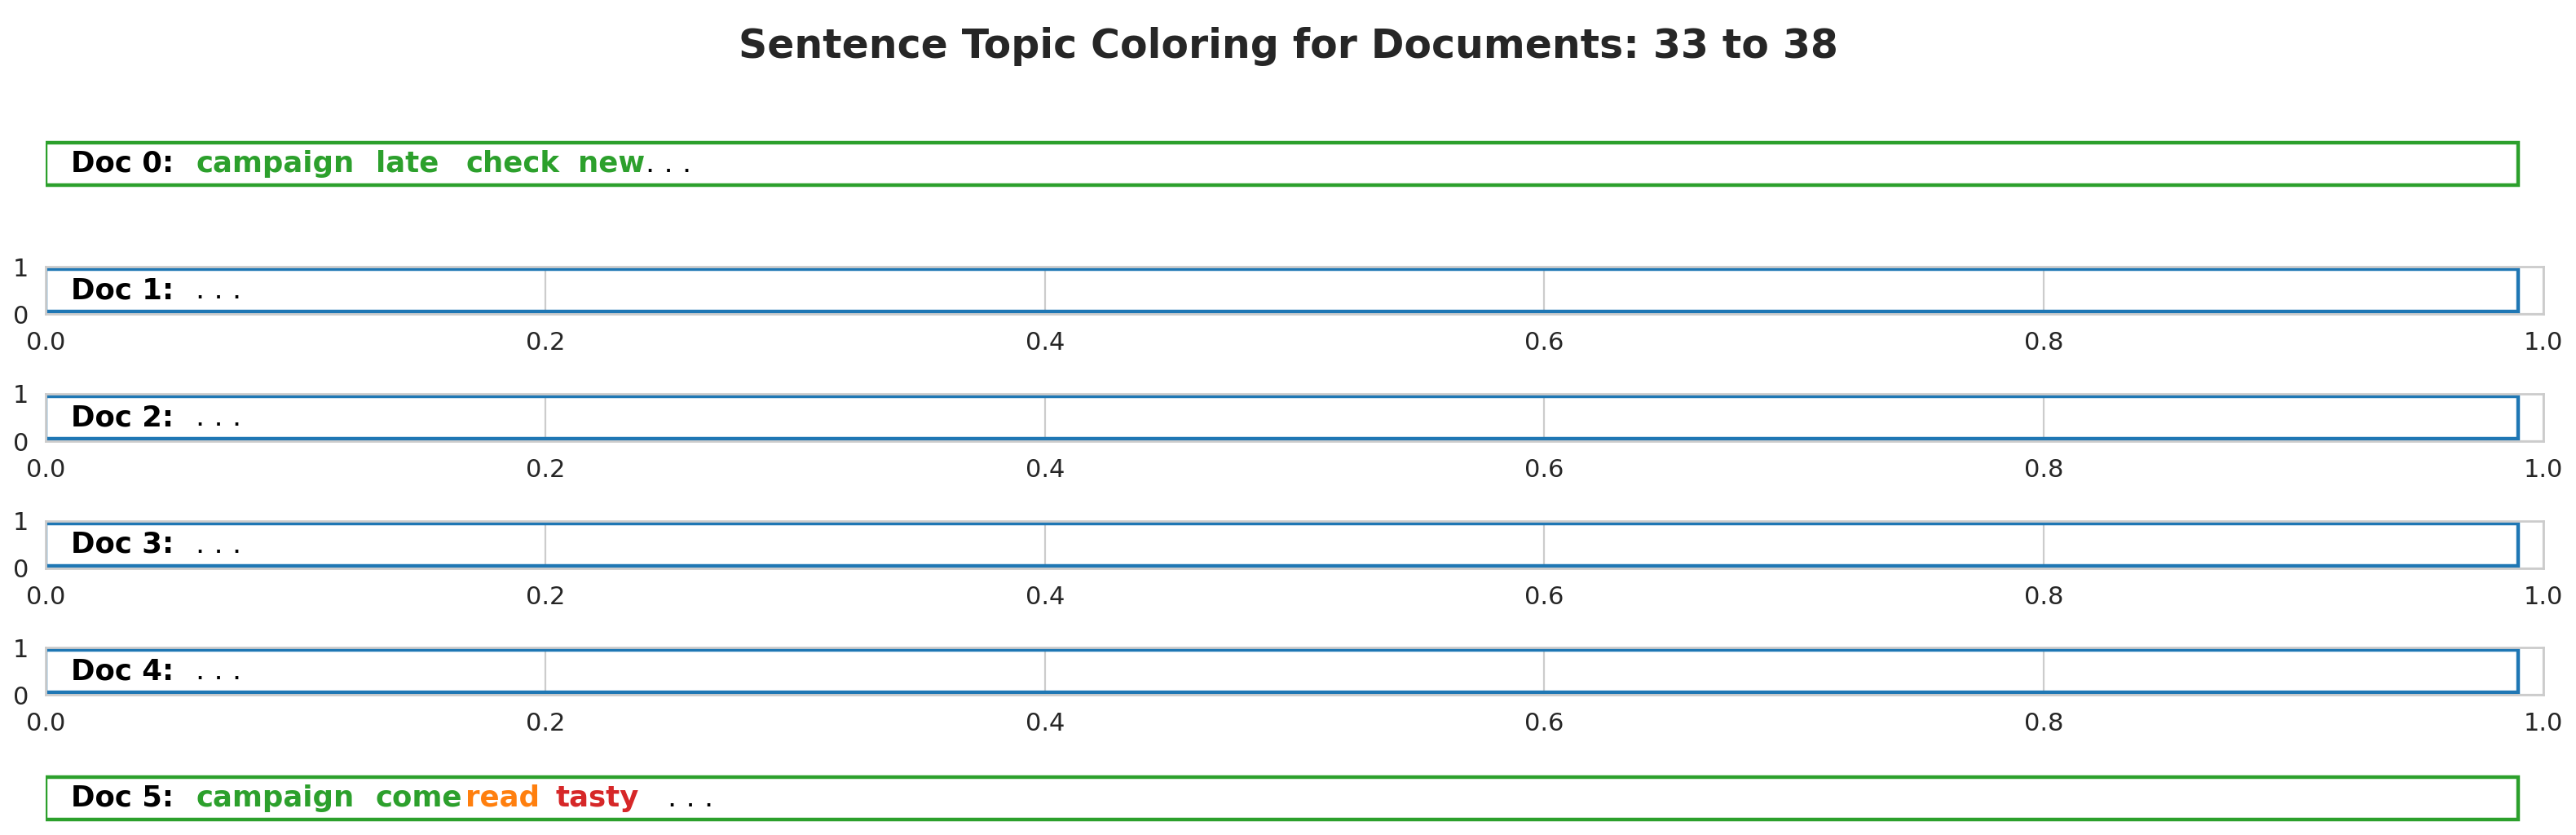

In [62]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus_tfidf, start = 33, end = 40):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart() 

In [64]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 552kB 18.1MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=748022613bed070c6d6bf7181e4298f6688d319aa8289adb3d166153cb2d49d9
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=c5af3b4e6f9ec4e27191de1bb51d604f9ec82a86a66e2973f22224c76dd12b23
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [65]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.288640  0.148668       1        1  26.324486
1      0.038094 -0.338282       2        1  26.043966
2      0.297470  0.187854       3        1  25.910545
3     -0.046924  0.001760       4        1  21.721001, topic_info=               Term       Freq      Total Category  logprob  loglift
19               ad  96.000000  96.000000  Default  30.0000  30.0000
35             come  95.000000  95.000000  Default  29.0000  29.0000
3          mcdonald  77.000000  77.000000  Default  28.0000  28.0000
9     advertisement  53.000000  53.000000  Default  27.0000  27.0000
34              new  51.000000  51.000000  Default  26.0000  26.0000
..              ...        ...        ...      ...      ...      ...
66            frite   2.776243   3.638632   Topic4  -4.9581   1.2564
4             story   2.556989   3.398464   Topic4  -5.0403   1.2424
118  retours_client   2.471062   3.435026   Topic4  -5.0745   1.1975
107             tax   1.887660   2.706283   Topic4  -5.3438   1.1667
119         assault   3.108268  14.892722   Topic4  -4.8451  -0.0399

[156 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
19        2  0.995518             ad
9         4  0.985471  advertisement
20        3  0.872180    advertising
63        3  0.887493           also
116       4  0.917150            app
...     ...       ...            ...
57        4  0.857868           well
38        1  0.967384           wifi
16        1  0.962934           work
60        2  0.950363          would
111       2  0.977930        youtube

[117 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

# **Topic Modeling with NMF**

In [0]:
import pandas as pd;
import numpy as np;
import scipy as sp;
import sklearn;
import sys;
from nltk.corpus import stopwords;
import nltk;
from gensim.models import ldamodel
import gensim.corpora;
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer;
from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;
import pickle;

In [0]:
train_headlines_sentences = [' '.join(text) for text in data_ready]
vectorizer = CountVectorizer(analyzer='word', max_features=5000);
x_counts = vectorizer.fit_transform(train_headlines_sentences);

transformer = TfidfTransformer(smooth_idf=False);
x_tfidf = transformer.fit_transform(x_counts);

In [0]:
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

In [70]:
#obtain a NMF model.
model = NMF(n_components=4, init='nndsvd',shuffle=True);
#fit the model
model.fit(xtfidf_norm)

NMF(alpha=0.0, beta_loss='frobenius', init='nndsvd', l1_ratio=0.0, max_iter=200,
    n_components=4, random_state=None, shuffle=True, solver='cd', tol=0.0001,
    verbose=0)

In [0]:
def get_nmf_topics(model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(4):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [72]:
get_nmf_topics(model, 20)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04
0,check,franchise,mcdonald,ca
1,soutkn,retours_client,sorry,fait
2,gsk,byebjx,macaron,faite
3,go,hksyig,salary,service
4,france,sjcitk,dlvr,exactement
5,pclt,zumn,restaurant,meme
6,xiq,dkozdt,retours_client,narrive
7,cefew,viadeo,succe,etant
8,rocdonald,cloud,wrap,bvrrtggbcbf
9,treemendous,jj,moin,mcglasse
